In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import json

#  Function to plot interactions with walls and non-self objects.
from scipy.stats import stats

def plot_all_interactions(game_types, agent_types):
    for game in game_types:
        plot_interaction(game, agent_types)

def plot_interaction(game_type, agent_types):
    w_count = []
    ns_count = []
    for agent in agent_types:
        w, ns = get_interaction_counts(game_type, agent)
        w_count.append(w)
        ns_count.append(ns)

    # Normalize the counts
    normalize(w_count, ns_count)

    agent_types = ["DQN Training", "Human", "Random", "Self Class"]
    labels = agent_types
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    wall = ax.bar(x - width/2, w_count, width, label='Wall', color="#00fa9a")
    non_self = ax.bar(x + width/2, ns_count, width, label='Non-self', color="#e500fa")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    game_titles = {
        "shuffleKeys_game": "Shuffle Keys",
        "contingency_game": "Contingency",
        "logic_game": "Logic"
    }

    ax.set_ylabel('Interaction Count (Normalized)', fontsize=10)
    ax.set_title( "Interaction Count: " + game_titles[game_type] + " Game", fontweight='bold', fontsize=15 )
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.tight_layout()
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#    plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

    plt.show()

def get_interaction_counts(game_type, agent_type):
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")
    w_count = 0
    ns_count = 0
    for file in files:
        data = json.load(open(file))
        wall_interactions = data.get("data")["wall_interactions"]
        ns_interactions = data.get("data")["ns_interactions"]
        w_count += sum(wall_interactions)
        ns_count += sum(ns_interactions)

    return w_count, ns_count

def normalize(w, ns):
    for i in range(len(w)):
        w_c = w[i]
        ns_c = ns[i]
        sum = w_c + ns_c
        if sum == 0:
            continue
        w[i] = w_c / sum
        ns[i] = ns_c / sum


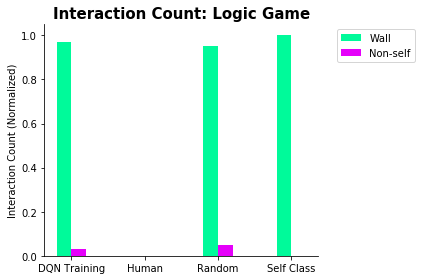

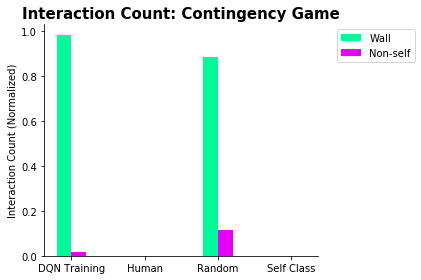

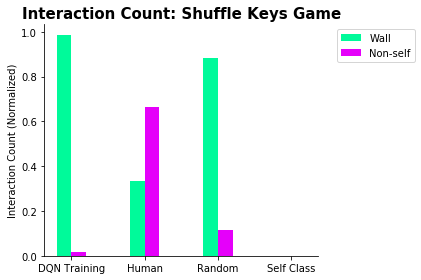

In [126]:
game_types = ["logic_game", "contingency_game", "shuffleKeys_game"]
agent_types = ["dqn_training", "human", "random", "self_class"]

# Plot interaction frequencies for each game and agent.
plot_all_interactions(game_types, agent_types)

In [2]:
# Function to plot bar chart for total steps.

def plot_all_total_steps(game_types, agent_types):
    for game in game_types:
        plot_total_steps(game, agent_types)

def plot_total_steps(game_type, agent_types):
    total_mean = []
    total_sem = []
    for agent in agent_types:
        mean, sem = get_mean_and_sem(game_type, agent)
        total_mean.append(mean)
        total_sem.append(sem)

    agent_types = ["DQN Training", "Human", "Random", "Self Class"]
    labels = agent_types
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    ts = ax.bar(x, total_mean, yerr=total_sem, width=width, color=["#03fc9d", "#0373fc", "#d002f5", "#fa0047"],
                ecolor='black', capsize=5, alpha=0.5)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    game_titles = {
        "shuffleKeys_game": "Shuffle Keys",
        "contingency_game": "Contingency",
        "logic_game": "Logic"
    }
    ax.set_ylabel('Average Total Steps')
    ax.set_title( "Total Steps: " + game_titles[game_type] + " Game", fontweight='bold', fontsize=15 )
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    #autolabel(ts)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

    fig.tight_layout()
    plt.show()

def get_mean_and_sem(game_type, agent_type):
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")
    if len(files) == 0:
        return 0, 0
    count = 0
    counts = []
    for file in files:
        data = json.load(open(file))
        step_counts = data.get("data")["steps"]
        count += sum(step_counts)
        counts.append( sum(step_counts) )

    mean = count / len(files)

    sem = stats.sem(counts, axis=None, ddof=0)
    return mean, sem

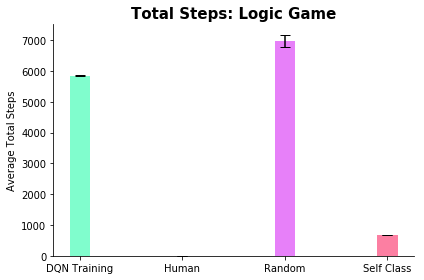

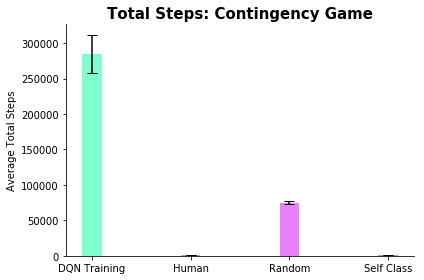

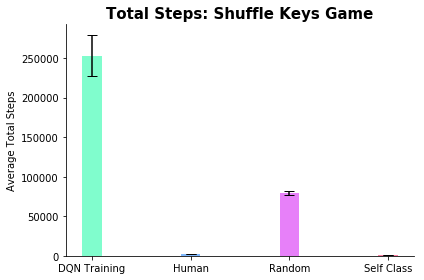

In [3]:
game_types = ["logic_game", "contingency_game", "shuffleKeys_game"]
agent_types = ["dqn_training", "human", "random", "self_class"]

# Plot interaction frequencies for each game and agent.
plot_all_total_steps(game_types, agent_types)

